# The fitting procedure in detail

To give further insight into the fitting process in <font color=green>Frankenstein</font> (`frank`), here we'll import and execute the code within `Python`. This is the same process performed when running `frank` [directly from the terminal](fit_from_terminal.rst), which is the quickest and easiest way to perform a fit. 

Using the DSHARP continuum observations of the protoplanetary disc AS 209 ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)) as the input dataset, `frank` will reconstruct the disc's 1D radial brightness profile by nonparametrically fitting the real component of the visibility distribution. 

Specifically `frank` will perform 4 steps in the fit, which we'll break into distinct calls (these are the steps taken in `fit.py`):<br>
1. Read in the data (`UVTable`) and parse the `.json` parameter file;
2. Determine the disc geometry (inclination, position angle and phase offset) by fitting a 2D Gaussian to the visibilities, then deproject them;
3. Fit the deprojected visibilities with a Gaussian process (~15 s) to yield a brightness profile;
4. Save the results: the brightness profile fit, visibility domain fit, `UVtables` with the **reprojected** fit and residuals between the input datafile and the reprojected fit, and a figure showing the fit and diagnostics. We'll also supply a CLEAN brightness profile for the disc as well as the synthesized CLEAN beam parameters, allowing `frank` to compare his fit to the CLEAN fit by: 
    - Convolving the fitted `frank` brightness profile with the synthesized beam to compare to the CLEAN profile and
    - Taking the discrete Hankel transform of the CLEAN profile to compare to the `frank` visibility domain fit.

In [the next tutorial](prior_sensitivity_and_uncertainty.ipynb) we'll use this same dataset to discuss the general analysis of a `frank` fit, including its sensitivity to hyperpriors and its typical underestimate of the recovered profile's uncertainty.

In [3]:
%matplotlib inline

In [ ]:
import frankenstein as frank # first name basis!

And let's import the functions from `fit.py` that we'll verbosely walk through.

In [ ]:
from fit import parse_parameters, load_uvdata, deproject_disc, perform_fit, output_results

## 1. Reading in the data and parameter values

Using a `UVTable` extracted from an `MSTable` [as demonstrated here](xx.xx) and the default parameter file `default_parameters.json`, let's start by reading both in.

In [ ]:
args, model = parse_parameters(parameter_file)

## 2. Determining the disc geometry and deprojecting the data

## 3. Fitting for the brightness profile

## 4. Saving the results and generating plots

A simple figure showing the fitted brightness profile, fitted visibility distribution and power spectrum reconstruction,

In [2]:
# Enables plotting of negative data on a log-scale
def plot_log_abs(x, y, **kwargs):
    c = plt.loglog(x, y, **kwargs)[0].get_color()
    
    kwargs = dict(kwargs) 
    kwargs['c'] = c
    kwargs['label'] = None
    plt.loglog(x, -y, ls='--', **kwargs)

def bin_uv_data(baselines, vis, weights, Nbins=512, recompute_weights=True):
    """
    Group the uv-data into bins.
    
    Parameters
    ----------
    baslines : 1D array,
        uv points (i.e. np.hypot(u,v))
    vis : 1D array,
        Visibility data
    weights : 1D array,
        Weights on the visibility data
    Nbins : int, default = 512
        Number of equally spaced in log bins to use.
    recompute_weights : bool, default = True
        If true, the weights will be recomputed for the number of points
        and variance in each bin. Otherwise the weight will be the sum of
        the weights for the points in each bin.
    
    Returns
    -------
    kbins : 1D array
        Centre of each uv-bin.
    bin_obs : 1D array
        Binned visibilites.
    bin_weights : 1D array,
        Binned weights.
        
    """
    log_lam = np.log(baselines)

    cnt, edges = np.histogram(log_lam, bins=Nbins)
    bin_wgt, _ = np.histogram(log_lam, bins=Nbins, weights=weights)
    bin_obs, _ = np.histogram(log_lam, bins=Nbins, weights=weights*vis)
    bin_ob2, _ = np.histogram(log_lam, bins=Nbins, weights=weights*vis**2)
    bin_lam, _ = np.histogram(log_lam, bins=Nbins, weights=weights*baselines)

    idx = cnt > 0
    bin_obs[idx] /= bin_wgt[idx]
    bin_ob2[idx] /= bin_wgt[idx]
    bin_lam[idx] /= bin_wgt[idx]

    if recompute_weights:
        idx = cnt > 1
        bin_wgt[idx] = (cnt[idx]-1) / (bin_ob2[idx] - bin_obs[idx]**2)

    # Clear empty bins
    idx = bin_wgt > 0
    bin_lam, bin_obs, bin_wgt = map(lambda x: x[idx], [bin_lam, bin_obs, bin_wgt])
        
    return bin_lam, bin_obs, bin_wgt

In [3]:
uv_AS209_DHSARP = np.load('AS209_continuum.npz')

The header shows that the uv points are already in units of $\lambda$, so we do not need to convert them. 


Let's just extract variables we need and confirm that the visibilities are complex

In [4]:
print(uv_AS209_DHSARP['header'])

u, v, vis, weights = [uv_AS209_DHSARP[k] for k in ['u', 'v', 'V', 'weights']]
print(vis.dtype)

{u'units': [u'lambda', u'lambda', u'Jy', u'Jy', u'None', u'Hz', u'None'], u'array_shape_orig': (1, 977774), u'datacolumn': u'DATA', u'columns': [u'u', u'v', u'V', u'weights', u'freqs', u'spws'], u'originalMS': u'/opt/services/djangoapp/media/MS/297/AS209_continuum_nopnt_nofl.ms'}
complex128


Load the radial profile. We store it in an object for convenience

Text(0.5,1,'CLEAN profile for AS 209')

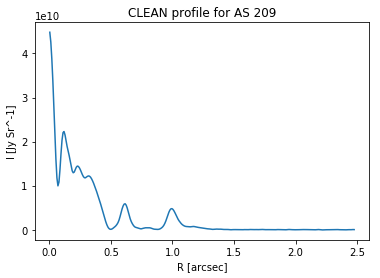

In [5]:
class InterpolatedDSHARPProfile(object):
    """Wrapper for the DSHARP radial profile text files"""
    def __init__(self, data_file, frequency):
        data = np.genfromtxt(data_file, unpack=True)

        r, T = data[1], data[4]

        wave = 299792458.0 / frequency

        I = 2 * 1.3806503e-23 * T  / wave**2
        I *= 1e26

        r /= rad_to_arcsec
            
        self.r = r
        self.Inu = I
 
AS209_profile = InterpolatedDSHARPProfile('AS_209_profile.dat', frequency=239e9)

plt.plot(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu)
plt.xlabel('R [arcsec]')
plt.ylabel('I [Jy Sr^-1]')
plt.title('CLEAN profile for AS 209')

## Next we need to deproject the dataset

Since AS 209 is not face on we need to de-project the disc before we can fit using an axis-symmetric model. We will do that by fitting a gaussian in visibility space.

In [6]:
from frankenstein.geometry import fit_geometry_gaussian, SourceGeometry

fitted_geometry = fit_geometry_gaussian(u,v,vis,weights)

print("Fitted geometry:")
print("\tPA, inclination (deg):\t\t {:.3f} {:.3f}".format(fitted_geometry.PA*180/np.pi, fitted_geometry.inc*180/np.pi))
print("\tPhase centre, dRA, dDec (mas):\t {:.3f} {:3f}".format(1e3*fitted_geometry.dRA, 1e3*fitted_geometry.dDec))


Fitted geometry:
	PA, inclination (deg):		 86.470 -33.933
	Phase centre, dRA, dDec (mas):	 0.863 -0.228760


The fit can also be performed without fitting for the phase centre:

In [7]:
fitted_geometry2 = fit_geometry_gaussian(u,v,vis,weights, phase_centre=(0,0))

print("Fitted geometry:")
print("\tPA, inclination (deg):\t\t {:.3f} {:.3f}".format(fitted_geometry2.PA*180/np.pi, fitted_geometry2.inc*180/np.pi))
print("\tPhase centre, dRA, dDec (mas):\t {:.3f} {:.3f}".format( 1e3*fitted_geometry2.dRA, 1e3*fitted_geometry2.dDec))

Fitted geometry:
	PA, inclination (deg):		 86.464 -33.935
	Phase centre, dRA, dDec (mas):	 0.000 0.000


Since these fitted results agree with the published values, we will use those

Text(0.5,1,'Binned visibilites')

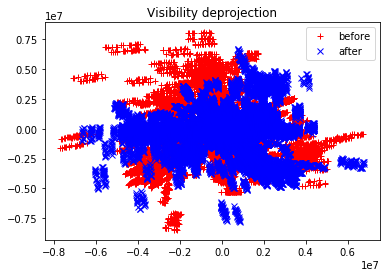

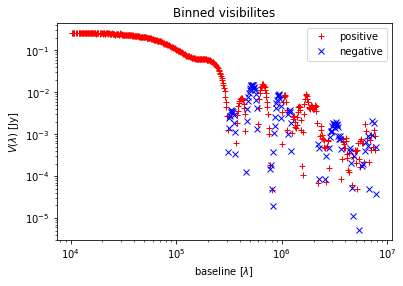

In [8]:
geometry = SourceGeometry(dRA=1.9e-3, dDec=-2.5e-3, inc=34.97*np.pi/180, PA=85.76*np.pi/180)

ub, vb, Vb = geometry.apply_correction(u,v, vis)

#Plot a subset of the uv-points before and after de-projecion:
plt.plot(u[::10],v[::10], 'r+', label='before')
plt.plot(ub[::10],vb[::10], 'bx', label='after')
plt.legend()
plt.title('Visibility deprojection')

# Make a binned version of the de-projected data
uv_bin, vis_bin, w_bin = bin_uv_data(np.hypot(ub,vb), Vb.real, weights)

plt.figure()
plt.loglog(uv_bin, +vis_bin.real, 'r+',label='positive')
plt.loglog(uv_bin, -vis_bin.real, 'bx',label='negative')
plt.legend()
plt.xlabel('baseline [$\lambda$]')
plt.ylabel('$V(\lambda)$ [Jy]')
plt.title('Binned visibilites')


## Now we fit the data

From the radial profile we know that the emission is close to zero beyond 1.6 arcsec, so lets fit to there.

Also use 300 bins, $\alpha=1.05$ and $w_s = 1/\sigma_s^2 = 0.01$

Note that we only fit the real component of the visibilities as an axi-symmetric source has zero imaginary component

In [9]:
from frankenstein import FrankFitter

Rmax = 1.6/rad_to_arcsec

FF = FrankFitter(Rmax, 300, geometry=geometry, alpha=1.05, weights_smooth=1e-2)

best_fit = FF.fit(u, v, vis, weights)

Let's plot the fit in real space and compare to CLEAN.

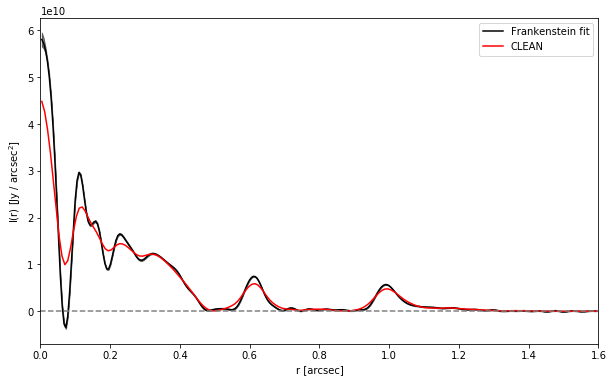

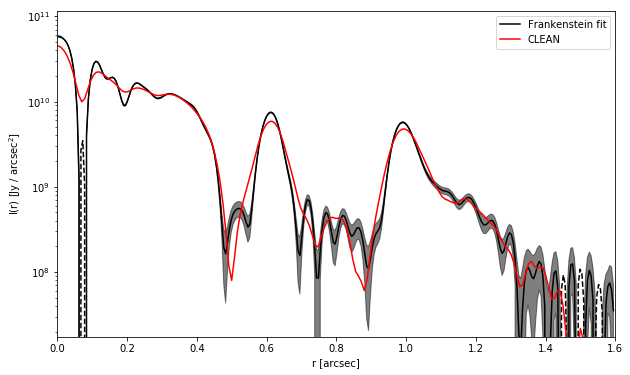

In [10]:
plt.figure(figsize=(10,6))

plt.plot(best_fit.r*rad_to_arcsec, best_fit.mean, 'k', label='Frankenstein fit')

# Plot an estimate of the confidence interval using the covariance matrix
err = np.diag(best_fit.covariance)**0.5
plt.fill_between( best_fit.r*rad_to_arcsec, best_fit.mean-err, best_fit.mean+err, color='k', alpha=0.5)
   
# Plot the CLEAN profile
plt.plot(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu, 'r', label='CLEAN')
    
plt.xlabel('r [arcsec]')
plt.ylabel('I(r) [Jy / arcsec${^2}$]')
plt.axhline(0, c='0.5', ls='--')
plt.xlim(0, 1.6)
plt.legend()

# Plot in logspace
plt.figure(figsize=(10,6))

plot_log_abs(best_fit.r*rad_to_arcsec, best_fit.mean, c='k', label='Frankenstein fit')
plt.fill_between(best_fit.r*rad_to_arcsec, best_fit.mean-err, best_fit.mean+err, color='k', alpha=0.5)

plot_log_abs(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu, c='r', label='CLEAN')

plt.xlabel('r [arcsec]')
plt.ylabel('I(r) [Jy / arcsec${^2}$]')
plt.ylim(ymin=3e-4*best_fit.mean.max())
plt.xscale('linear')
plt.xlim(0, 1.6)
plt.legend()

Now let's compare the visibilities. Note the Hankel Transform of the CLEAN profile is low beyond $2\times 10^6 \lambda$ because of beam convolution.

(1e-05, 1.049530344199105)

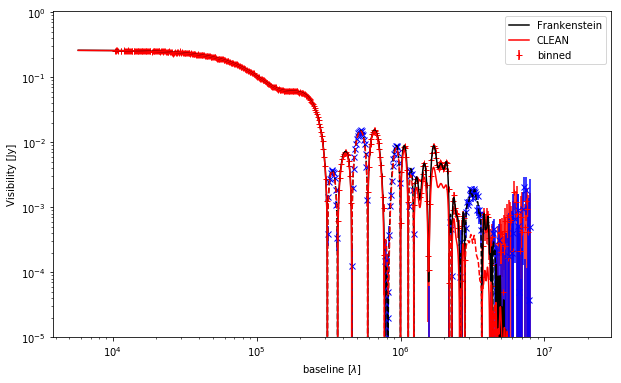

In [11]:
# Plot the visibilies
plt.figure(figsize=(10,6))
l = plt.errorbar(uv_bin, vis_bin, yerr=w_bin**-0.5,marker='+', ls='none', c='r', label='binned', zorder=-1)
plt.errorbar(uv_bin, -vis_bin, yerr=w_bin**-0.5,marker='x', ls='none', c='b', zorder=-1)

uv = np.hypot(u, v)
ki = np.logspace(np.log10(min(uv.min(), best_fit.q[ 0])) - 0.3, 
                 np.log10(max(uv.max(), best_fit.q[-1])) + 0.0,
                 10**4)

plot_log_abs(ki, best_fit.predict_deprojected(ki), c='k', label='Frankenstein')

# Plot also the predicted visibilities of the CLEAN image
from frankenstein.hankel import DiscreteHankelTransform
dht = DiscreteHankelTransform(Rmax,300)
plot_log_abs(ki, 
             best_fit.predict_deprojected(ki, 
                                     I=np.interp(dht.r, 
                                                 AS209_profile.r, 
                                                 AS209_profile.Inu)),
             c='r', label='CLEAN')

plt.legend()
plt.xlabel('baseline [$\lambda$]')
plt.ylabel('Visibility [Jy]')
plt.ylim(ymin=1e-5)

We could also use [CASA](https://casa.nrao.edu) to CLEAN (thereby convolving with the synthesized beam) the `frank` fit image and residual image to compare with the CLEAN model image.

## Sensitivity to parameters

A better way to understand the uncertainty on the reconstructed profile is to compare fits with different choices of input parameters ($\alpha$, $w_s$). Here we compare the default fit to one with $\alpha$ close to 1, but a stronger smoothing of the power-spectrum.

In [12]:
FF2 = FrankFitter(Rmax, 300,  geometry=geometry, alpha=1.0, weights_smooth=1.0)

fit2 = FF2.fit(u, v, vis, weights)
err2 = np.diag(fit2.covariance)**0.5

Looking at the real-space profile we can see that the second fit has more wiggles on small scales, but also a larger errorbar

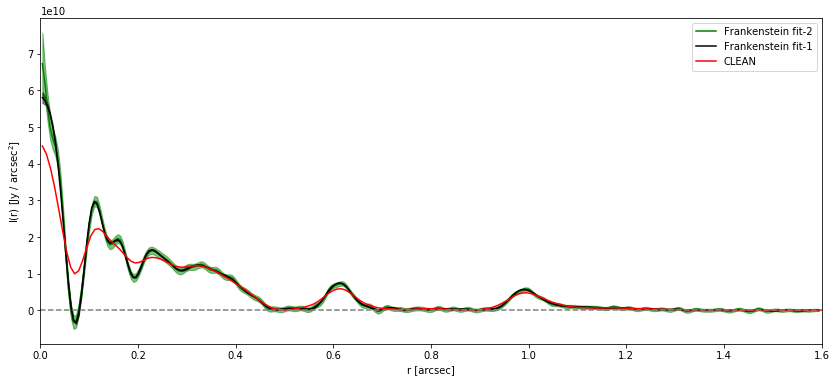

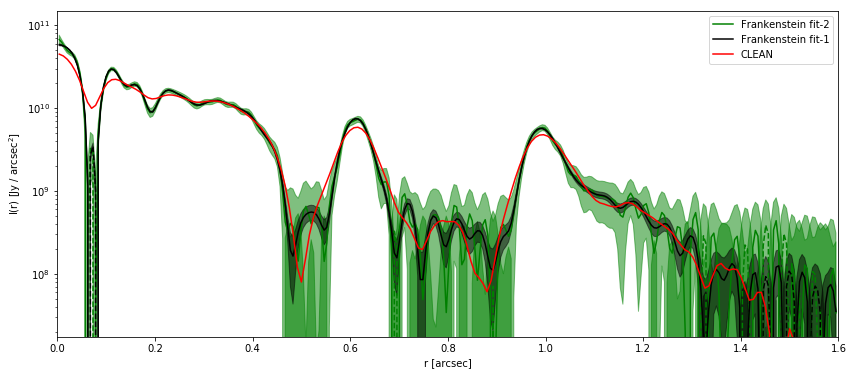

In [13]:
# Plot in real-space
plt.figure(figsize=(14,6))

plt.plot(fit2.r*rad_to_arcsec, fit2.mean, c='g', label='Frankenstein fit-2')
plt.fill_between(best_fit.r*rad_to_arcsec, fit2.mean-err2, fit2.mean+err2, color='g', alpha=0.5)

plt.plot(best_fit.r*rad_to_arcsec, best_fit.mean, c='k', label='Frankenstein fit-1')
plt.fill_between(best_fit.r*rad_to_arcsec, best_fit.mean-err, best_fit.mean+err, color='k', alpha=0.5)

plt.plot(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu, c='r', label='CLEAN')

plt.xlabel('r [arcsec]')
plt.ylabel('I(r) [Jy / arcsec${^2}$]')
plt.axhline(0, c='0.5', ls='--')
plt.xscale('linear')
plt.xlim(0, 1.6)
plt.legend()

# Plot in log-space
plt.figure(figsize=(14,6))

plot_log_abs(fit2.r*rad_to_arcsec, fit2.mean, c='g', label='Frankenstein fit-2')
plt.fill_between(fit2.r*rad_to_arcsec, fit2.mean-err2, fit2.mean+err2, color='g', alpha=0.5)
plt.fill_between(fit2.r*rad_to_arcsec, -fit2.mean-err2, -fit2.mean+err2, color='g', alpha=0.5)

plot_log_abs(best_fit.r*rad_to_arcsec, best_fit.mean, c='k', label='Frankenstein fit-1')
plt.fill_between(best_fit.r*rad_to_arcsec, best_fit.mean-err, best_fit.mean+err, color='k', alpha=0.5)
plt.fill_between(best_fit.r*rad_to_arcsec, -best_fit.mean-err, -best_fit.mean+err, color='k', alpha=0.5)

plot_log_abs(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu, c='r', label='CLEAN')

plt.xlabel('r [arcsec]')
plt.ylabel('I(r) [Jy / arcsec${^2}$]')
plt.axhline(0, c='0.5', ls='--')
plt.ylim(ymin=3e-4*best_fit.mean.max())
plt.xscale('linear')
plt.xlim(0, 1.6)
plt.legend()

Comparing these in visibility-space you can see that the reason the second fit has more wiggles is that its attempting to fit out longer baseline, where the data is noisy.

However, its worth noting that even this fit is not attemting to fully fit these data, as the reconstructed visibility amplitudes are lower than the observed visibilities for both fits.

(1e-05, 1.049530344199105)

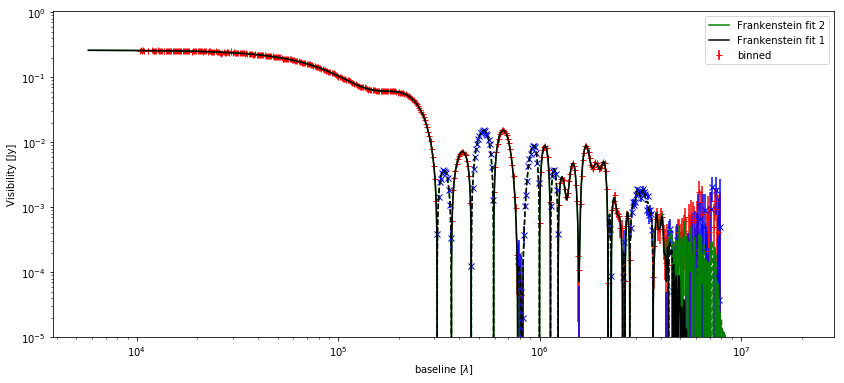

In [14]:
# Plot the visibilies
plt.figure(figsize=(14,6))

l = plt.errorbar(uv_bin, vis_bin, yerr=w_bin**-0.5,marker='+', ls='none', c='r', label='binned', zorder=-1)
plt.errorbar(uv_bin, -vis_bin, yerr=w_bin**-0.5,marker='x', ls='none', c='b', zorder=-1)

ki = np.logspace(np.log10(min(uv.min(), best_fit.q[ 0])) - 0.3, 
                 np.log10(max(uv.max(), best_fit.q[-1])) + 0.0,
                 10**4)

plot_log_abs(ki, fit2.predict_deprojected(ki), c='g', label='Frankenstein fit 2')
plot_log_abs(ki, best_fit.predict_deprojected(ki),  c='k', label='Frankenstein fit 1')

plt.legend()
plt.xlabel('baseline [$\lambda$]')
plt.ylabel('Visibility [Jy]')
plt.ylim(ymin=1e-5)

## Understanding the behaviour 

To appreciate why the two fits are behaving as they do, it is useful to look the power-spectrum coefficients, $p$, of the the two fits. 

In the first fit the smoothing strength, $w_s$, is weaker while $\alpha$ is higher. The lower smoothing strengths means that $p$ shows more wiggles where the signal-to-noise of the data is good. This is because the weak smoothing allows some small scale variation in the power-spectrum.

Below we interpret why these choices have the effects they do.

Text(0,0.5,'Power spectrum coefficient')

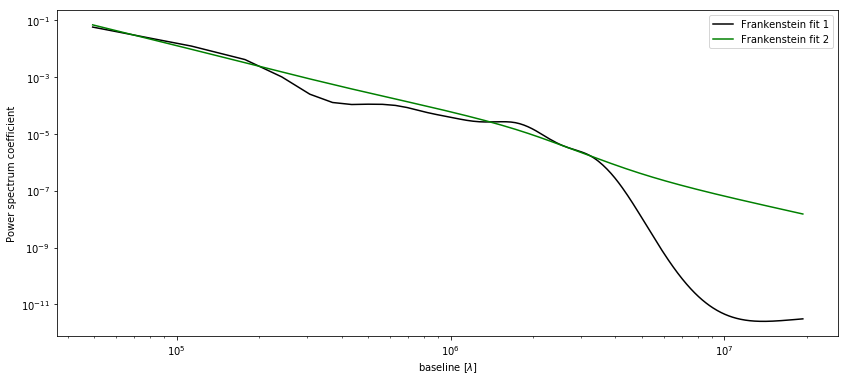

In [15]:
plt.figure(figsize=(14,6))

plt.loglog(best_fit.q, best_fit.power_spectrum, c='k', label='Frankenstein fit 1')
plt.loglog(fit2.q, fit2.power_spectrum, c='g', label='Frankenstein fit 2')

plt.legend()
plt.xlabel('baseline [$\lambda$]')
plt.ylabel('Power spectrum coefficient')


### Damping of high frequency variations
The second noticeable difference is that the first fit has much lower amplitude at long baseline. This is because the higher $\alpha$, while still only midly above unity, means that the prior on $p$ is peaked at low amplitude ($p_0 = 10^{-15}$). Since the signal to noise is poor at large long baseline, $p$ is dominated by the prior. This has two effects on the reconstructed profile: 1) high frequency variations are damped and 2) the quoted uncertainty is small.

The damping of high frequency variations is easily understood because the power-spectum is the prior on the reconstructed brightness. The low uncertainty arises because the uncertainty is also determined by power-spectrum in regions of poor signal-to-noise. 

At this stage, we note that one can try to get an increased uncertainty on the first best_fitution by factoring in the uncertainty on the power-spectrum parameters, which are essentiallly unconstrained by the data (FrankFitter provides a method to draw sets of $p$ from a log-normal approximation to the posterior for $p$). However, little is to be gained from this because the choice of prior, because $\alpha = 1.05$ is sufficiently constraining that $p$ at large $\lambda$ never reaches high enough amplitude.

### A better uncertainty estimate
However, all is not lost. The second model produces a more reasonable estimate of the true uncertainty on the profile due to the missing data at long baseline. In the second model the choice of $\alpha = 1.0$ does not prejudice against variations on scales where there is no data - the prior is flat in log-space. However, the use of strong smoothing, $w_s = 1$, constrains the power-spectrum to be close to a power-law. This provides a sensible extrapolation to long baselines and thus prior on the reconstructed brightness includes a sensible esimtate for the uncertainty on these scales.

The resulting profile from the second fit thus has a better estimate of the uncertainty. However, this has come with the cost of fitting the high frequency data that is dominated by noise.

### Caution!
Varying the different parameters associated with the fit offers a way to estimate the error in the reconstructed profile - both by examining how senstive the fit is to the choice of these parameters and by choosing parameters that provide a sensible error estimate.

Even so, all of the reconstructed profiles produce a negative intensity in the first gap, and none of the uncertainty regions overlap zero. Since the negative brightness is very likely to be wrong, this points to a remaining systematic uncertainty that is still not accounted for.